# LDA (Topic Modelling)

In this notebook I implement LDA in combination with sentiment models to create a topic-specific sentiment signal. The work is important as a clear contrast to the finBERT model because LDA is a probabilistic graphical model, not a neural network. It is highly relevant to the financial domain because stock prices react differently to different topics [1] - a negative sentiment about earnings might cause a crash in a stock whereas a negative sentiment weather might be ignored. LDA prceicely captures this nuance by interpreting the topic of the headline in contrast to finBERT which tells you what the sentiment of the headline is.

The workflow of this notebook will be as follows [2]:
* Topic Extraction: run LDA on the headlines to find some number, $K$, of topics.
* Identify Topic Words: for each topic get the top $X$ words.
* Score the Topics: use a sentiment dictionary to score each topic word in terms of their sentiment.
* Calculate document score: work out which topics comprise each headline (and in what proportions) and use this combined with the topic scores to calculate the overall score of the headline.
* Assess the performance of the model by comparing the predicted trade signal/ sentiment of each headline and its given label in the dataset.

## Installation of software

In [1]:
!pip install datasets
!pip install gensim
!pip install pysentiment2
!pip install nltk
!pip install pyLDAvis
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.9 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
import pandas as pd
import requests
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
from gensim import corpora
from nltk.corpus import stopwords
import pysentiment2 as ps
import nltk
import os
import spacy
from gensim.models.phrases import Phrases, Phraser
from gensim.models import LdaModel
from pprint import pprint
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action="ignore", message=r"datetime.datetime.utcnow")

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('popular')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data.

True

## Data

In [4]:
data = load_dataset("FinGPT/fingpt-sentiment-train", split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/529 [00:00<?, ?B/s]

data/train-00000-of-00001-dabab110260ac9(…):   0%|          | 0.00/6.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/76772 [00:00<?, ? examples/s]

Below I implement the same mapping of the data as in the finBERT analysis so that we work with just 5 sentiments: 'negative', 'moderate negative', 'neutral', 'moderate positive', 'positive'.

In [5]:
mapping_5 = {
    "strong negative": "negative",
    "moderately negative": "moderate_negative",
    "mildly negative": "moderate_negative",
    "negative": "negative",
    "neutral": "neutral",
    "mildly positive": "moderate_positive",
    "moderately positive": "moderate_positive",
    "positive": "positive",
    "strong positive": "positive"
}

In [6]:
def map_to_5(example):
    example["label_5"] = mapping_5[example["output"]]
    return example

dataset = data.map(map_to_5)

Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

In [7]:
df = pd.DataFrame(dataset)

# visualise first few rows of data
df.head()

,input,output,instruction,label_5
0,"Teollisuuden Voima Oyj , the Finnish utility k...",neutral,What is the sentiment of this news? Please cho...,neutral
1,Sanofi poaches AstraZeneca scientist as new re...,neutral,What is the sentiment of this news? Please cho...,neutral
2,Starbucks says the workers violated safety pol...,moderately negative,What is the sentiment of this news? Please cho...,moderate_negative
3,$brcm raises revenue forecast,positive,What is the sentiment of this tweet? Please ch...,positive
4,Google parent Alphabet Inc. reported revenue a...,moderately negative,What is the sentiment of this news? Please cho...,moderate_negative


In [9]:
# extract 'input' column which contains the news text and convert it to a list
docs = df['input'].tolist()

# check this worked worked by printing the first doc
print(f"Successfully loaded {len(docs)} documents.")
print(f"First document preview: {docs[0][:100]}...")

Successfully loaded 76772 documents.
First document preview: Teollisuuden Voima Oyj , the Finnish utility known as TVO , said it shortlisted Mitsubishi Heavy s E...


## Pre-processing for LDA

This step is crucial for LDA, it is more sensitive to noise than finBERT so we will need to pre-process more aggressively [3]. The 4 key pre-processing steps I will perform are:
* Tokenize: splitting the text into individual words or phrases (by identifying word boundaries like spaces and punctuation);
* Build bigrams: e.g., keep "interest_rate" together rather than "interest" and "rate";
* Remove stopwords: this will include the standard list of stopwords as well as "finance" specifics like 'said', 'market', 'stock';
* Lemmatize: reduce words to their base or root form to group variations of the same word together.

I will use spaCy to keep only specific POS tags (Noun, Adj, Verb, Adv) because 'connecting' words (Prepositions) are usually noise for LDA [4].

The order in which these steps are conducted is important because, for example, detecting phrases like "stock_market" is easier before you chop words down to their roots or remove connecting words. Furthermore, creating bigrams before removing stop words ensures we don't remove standard stopwords which are actually semantically significant in the context of neighbouring words e.g. 'market' will be removed but but 'oil_market' wouldn't.

In [10]:
# download spacy model
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# prep stopwords
stop_words = stopwords.words('english')
finance_stopwords = [
    'said', 'say', 'says', 'reporting', 'market', 'share', 'stock',
    'price', 'company', 'corp', 'inc', 'ltd', 'shareholder', 'analyst',
    'expect', 'year', 'quarter', 'month', 'week', 'day'
]
stop_words.extend(finance_stopwords)

In [11]:
# the pre-processing pipeline

def process_text_for_lda(docs):
    """
    Input: List of raw string documents
    Output: List of lists (tokens) ready for LDA
    """

    # tokenize
    docs_tokens = [gensim.utils.simple_preprocess(doc, deacc=True) for doc in docs]

    # build bigrams
    bigram_model = Phrases(docs_tokens, min_count=5, threshold=100)
    bigram_mod = Phraser(bigram_model) # optimises the model for speed

    docs_bigrams = [bigram_mod[doc] for doc in docs_tokens]

    # remove stopwords & lemmatize
    data_ready = []
    allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']

    for doc in docs_bigrams:
        text = " ".join(doc)
        doc_spacy = nlp(text)

        # extract Lemmas if word is not a stopwod and is the correct Part of Speech
        tokens = [
            token.lemma_ for token in doc_spacy
            if token.pos_ in allowed_postags
            and token.lemma_ not in stop_words
            and len(token.lemma_) > 2 # Remove tiny artifacts
        ]

        data_ready.append(tokens)

    return data_ready

Below is the code chunk I originally used. This took a very long time to run so below I include the optimised version [5] of the pipeline which I used instead. This runs in less than half the time of the original pipeline.

In [12]:
# run pipeline on 'docs' list

# final_docs = process_text_for_lda(docs)

# print("Comparison:")
# print(f"Original: {docs[0][:100]}...")
# print(f"Processed: {final_docs[0]}")

In [13]:
# optimised pipeline

def process_text_for_lda_optimized(docs):

    docs_tokens = [gensim.utils.simple_preprocess(doc, deacc=True) for doc in docs]

    bigram_model = Phrases(docs_tokens, min_count=5, threshold=100)
    bigram_mod = Phraser(bigram_model)
    docs_bigrams = [bigram_mod[doc] for doc in docs_tokens]

    # nlp.pipe expects a list of strings
    data_as_strings = [" ".join(doc) for doc in docs_bigrams]

    data_ready = []
    allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']

    # nlp.pipe processes in batches (much faster than a loop)
    for doc in tqdm(nlp.pipe(data_as_strings, batch_size=2000), total=len(data_as_strings)):

        tokens = [
            token.lemma_ for token in doc
            if token.pos_ in allowed_postags
            and token.lemma_ not in stop_words
            and len(token.lemma_) > 2
        ]
        data_ready.append(tokens)

    return data_ready

In [14]:
# use the faster pipeline

final_docs = process_text_for_lda_optimized(docs)

print("Comparison:")
print(f"Original: {docs[0][:100]}...")
print(f"Processed: {final_docs[0]}")

100%|██████████| 76772/76772 [02:08<00:00, 599.29it/s] 


Comparison:
Original: Teollisuuden Voima Oyj , the Finnish utility known as TVO , said it shortlisted Mitsubishi Heavy s E...
Processed: ['teollisuuden_voima', 'oyj', 'finnish', 'utility', 'know', 'heavy', 'model', 'reactor', 'energy', 'korea_hydro', 'nuclear_power']


## Dictionary & Corpus

Now we make a dictionary using the gensim package and filter out extreme values (i.e. very rare or common words). And then from this we create the corpus - a list of documents, each of which is a list of words which will be treated as a bag of words in the LDA model.

In [15]:
dictionary = corpora.Dictionary(final_docs)
dictionary.filter_extremes(no_below=10, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in final_docs]

## Constructing LDA model

I now define the model with a specified corpus and dictionary which I just created above. I will start off by trying $K=15$ topics and then tune this parameter.

In [16]:
lda_model = lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=15,
        random_state=42,
        update_every=1,
        chunksize=2000, # process 2000 docs at a time
        passes=10,      # train on the data 10 times for better quality
        alpha='auto',
        per_word_topics=True
        )

In [17]:
# show the top 10 words for each topic to inspect model
print("Discovered topics:")
pprint(lda_model.print_topics(num_topics=15, num_words=10))

Discovered topics:
[(0,
  '0.062*"new" + 0.043*"business" + 0.036*"service" + 0.027*"group" + '
  '0.022*"announce" + 0.021*"include" + 0.021*"well" + 0.019*"financial" + '
  '0.019*"product" + 0.019*"technology"'),
 (1,
  '0.064*"buy" + 0.048*"today" + 0.048*"investor" + 0.046*"growth" + '
  '0.042*"first" + 0.036*"long" + 0.035*"good" + 0.034*"time" + 0.033*"see" + '
  '0.027*"big"'),
 (2,
  '0.071*"also" + 0.043*"order" + 0.036*"datum" + 0.035*"provide" + '
  '0.033*"system" + 0.033*"agreement" + 0.032*"sign" + 0.029*"build" + '
  '0.024*"future" + 0.020*"bounce"'),
 (3,
  '0.057*"dividend" + 0.042*"contract" + 0.040*"offer" + 0.038*"cost" + '
  '0.030*"bank" + 0.029*"finland" + 0.029*"pay" + 0.024*"construction" + '
  '0.022*"annual" + 0.022*"issue"'),
 (4,
  '0.052*"percent" + 0.039*"capital" + 0.034*"fund" + 0.032*"return" + '
  '0.027*"pct" + 0.027*"rate" + 0.023*"positive" + 0.023*"turn" + '
  '0.021*"interest" + 0.020*"amount"'),
 (5,
  '0.054*"plan" + 0.039*"close" + 0.031*"p

In [18]:
# compute Coherence Score to measure semantic simialrity of words in topics
coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=final_docs,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda:.4f}')


Coherence Score: 0.3899


Since this isn't a great coherence score we will try re-running the model with different amounts of topics to see if this improves the score. If not we need to return to our pre-processing and improve that.

In the evidence notebook you can see all the different values of $K$ I tried, here I just include a few to show the non-convex behaviour of the objective function which I observe. I tried the values ${4,6,8,10,12,15}$ during this training step.

In [19]:
lda_model_2 = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=42,
    update_every=1,
    chunksize=2000,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [20]:
coherence_model_lda_2 = CoherenceModel(
    model=lda_model_2,
    texts=final_docs,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_lda_2 = coherence_model_lda_2.get_coherence()
print(f'\nCoherence Score: {coherence_lda_2:.4f}')


Coherence Score: 0.4422


So there has been an improvement by reducing the number of topics.

In [21]:
lda_model_4 = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=8,
        random_state=42,
        update_every=1,
        chunksize=2000,
        passes=10,
        alpha='auto',
        per_word_topics=True
        )

In [22]:
coherence_model_lda_4 = CoherenceModel(
    model=lda_model_4,
    texts=final_docs,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_lda_4 = coherence_model_lda_4.get_coherence()
print(f'\nCoherence Score: {coherence_lda_4:.4f}')


Coherence Score: 0.4651


In [23]:
lda_model_6 = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=6,
    random_state=42,
    update_every=1,
    chunksize=2000,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [24]:
coherence_model_lda_6 = CoherenceModel(
    model=lda_model_6,
    texts=final_docs,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_lda_6 = coherence_model_lda_6.get_coherence()
print(f'\nCoherence Score: {coherence_lda_6:.4f}')


Coherence Score: 0.4383


So from performing hyperparameter tuning on the number of topics we establish that $8$ is the best choice. The decrease of coherence as the number of topics increased after peaking at $8$ suggests that the dataset contains a small number of broad financial themes rather than many granular ones. However the coherence score for $8$ topics still isn't excellent so a valuable extension would be to return to the data pre-processing step and adjust it to see if the performance improves.

During this step I also came across and important point for the scalability of this model - using LdaMulticore. The standard LdaModel runs on a single CPU core whereas LdaMulticore is a parallelised implementation which uses all available cores [4] (here I have access to 2 through Colab). I will implement LdaMulitcore below to demonstrate the speed difference.

In [25]:
lda_model_fast = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=8,
        workers=2 # use 2 cores (Colab limit)
        )

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=734) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=734) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


This ran in 30secs compared to over 2mins for all the other standard LdaModels. Let's check its coherence score.

In [26]:
coherence_model_lda_fast = CoherenceModel(
    model=lda_model_fast,
    texts=final_docs,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_lda_fast = coherence_model_lda_fast.get_coherence()
print(f'\nCoherence Score: {coherence_lda_fast:.4f}')


Coherence Score: 0.3564


The coherence score, for the same number of topics, of the LdaMulticore is significantly lower than that of the standard LdaModel. So there is clearly a tradeoff between speed and accuracy here, which is not surprising due to the nature of the randomness in parallel processing and the fact that LdaMulticore is optimised specifically for speed.

## Visualising the topics

Here we use pyLDAvis to create interactive plots. I will do this for the $15$ topic model and $8$ topic model and compare them.

In [27]:
pyLDAvis.enable_notebook()

vis_data = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
# sort_topics=False keeps the topic IDs consistent with the Gensim model

vis_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.188567 -0.169090       1        1  14.018663
1     -0.216620  0.157610       2        1  10.432178
2      0.084817 -0.045208       3        1   4.562036
3     -0.061336 -0.162120       4        1   5.286665
4      0.101312  0.130415       5        1   3.679038
5     -0.050957 -0.138820       6        1   6.025722
6      0.020083  0.103962       7        1   6.948953
7      0.015139 -0.007370       8        1   7.010451
8     -0.270953  0.001354       9        1   6.566091
9      0.020400  0.124212      10        1   7.559766
10     0.058771  0.119472      11        1   5.598547
11     0.163211 -0.132564      12        1   4.597796
12     0.076987  0.056418      13        1   6.140196
13     0.085118  0.152161      14        1   5.242735
14     0.162593 -0.190432      15        1   6.331164, topic_info=         Term         Freq        Total Category  logprob  loglift
40      https  5910.000000  5910.000000  Default  30.0000  30.0000
116      sale  4126.000000  4126.000000  Default  29.0000  29.0000
28     report  3617.000000  3617.000000  Default  28.0000  28.0000
9         new  4467.000000  4467.000000  Default  27.0000  27.0000
23    earning  3223.000000  3223.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
624      date   262.039458   263.068990  Topic15  -4.8257   2.7558
440    reduce   261.553400   262.582933  Topic15  -4.8276   2.7558
589       let   239.908839   240.938372  Topic15  -4.9139   2.7554
1236   reject   236.155257   237.184789  Topic15  -4.9297   2.7553
83     update   493.954057  1225.424180  Topic15  -4.1918   1.8511

[538 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
616       8  0.996982       aapl
1070      3  0.995997       able
393       1  0.998651     accord
463      11  0.995433    account
810       1  0.998408    acquire
...     ...       ...        ...
125       6  0.998372      world
560       4  0.998667      worth
699       9  0.994500  yesterday
1594      8  0.993221        yet
1439      9  0.990166    youtube

[589 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [28]:
pyLDAvis.enable_notebook()

vis_data_4 = gensimvis.prepare(lda_model_4, corpus, dictionary, sort_topics=False)

vis_data_4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.267373  0.131727       1        1  15.882065
1     -0.169648  0.130695       2        1  16.071032
2      0.297374  0.084596       3        1   9.083873
3     -0.116904 -0.063205       4        1  14.266937
4     -0.077847  0.009041       5        1   7.993880
5      0.002271 -0.254163       6        1   9.080237
6     -0.197550  0.231237       7        1   9.250766
7     -0.005070 -0.269929       8        1  18.371210, topic_info=       Term         Freq        Total Category  logprob  loglift
116    sale  3767.000000  3767.000000  Default  30.0000  30.0000
40    https  5208.000000  5208.000000  Default  29.0000  29.0000
9       new  3963.000000  3963.000000  Default  28.0000  28.0000
28   report  3310.000000  3310.000000  Default  27.0000  27.0000
98   profit  2631.000000  2631.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
501    give   623.260037   626.827867   Topic8  -5.0245   1.6887
336   trade  1260.362111  1625.068035   Topic8  -4.3204   1.4402
173   right   774.269912   856.554881   Topic8  -4.8076   1.5934
9       new   776.319691  3963.226938   Topic8  -4.8049   0.0641
309    make   640.901587  1692.259935   Topic8  -4.9966   0.7234

[341 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
393       1  0.999417       accord
463       2  0.008849      account
463       7  0.986609      account
810       1  0.998887      acquire
470       1  0.998280  acquisition
...     ...       ...          ...
339       3  0.997446          win
339       8  0.001523          win
124       1  0.999137         work
125       8  0.999445        world
560       3  0.998274        worth

[406 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

Comparing these 2 plots clearly indicates why $8$ topics is the better choice - there is much less overlap and clustering of topic 'blobs' in the $8$ topic model. However an important feature of the $8$ topic plot is that one of the topic blobs is entirely contained within another, and these 2 topics don't share loads of topic words so a likely explanation is that topic $6$ is a sub-topic of topic $8$. This prompts me to try re-running with $7$ topics.

In [29]:
lda_model_7 = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=7,
        random_state=42,
        update_every=1,
        chunksize=2000,
        passes=10,
        alpha='auto',
        per_word_topics=True
        )

coherence_model_lda_7 = CoherenceModel(
    model=lda_model_7,
    texts=final_docs,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_lda_7 = coherence_model_lda_7.get_coherence()
print(f'\nCoherence Score: {coherence_lda_7:.4f}')


Coherence Score: 0.4064


In [30]:
pyLDAvis.enable_notebook()

vis_data_7 = gensimvis.prepare(lda_model_7, corpus, dictionary, sort_topics=False)

vis_data_7

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.213908  0.056797       1        1   9.989288
1     -0.155248 -0.023708       2        1  17.978789
2      0.050642 -0.367112       3        1  15.700848
3     -0.216297  0.125980       4        1  19.645721
4     -0.199058 -0.070503       5        1  16.405332
5      0.039192  0.256325       6        1  13.043111
6      0.266862  0.022222       7        1   7.236912, topic_info=            Term         Freq        Total Category  logprob  loglift
40         https  5228.000000  5228.000000  Default  30.0000  30.0000
9            new  3977.000000  3977.000000  Default  29.0000  29.0000
116         sale  3956.000000  3956.000000  Default  28.0000  28.0000
28        report  3213.000000  3213.000000  Default  27.0000  27.0000
44           buy  3068.000000  3068.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1241      review   220.608465   221.456471   Topic7  -5.1315   2.6221
461   nine_month   218.451248   219.300842   Topic7  -5.1414   2.6221
800        ready   346.045249   347.436611   Topic7  -4.6813   2.6220
1184     outlook   306.163730   499.332858   Topic7  -4.8038   2.1368
878       nearly   231.733889   342.282982   Topic7  -5.0823   2.2359

[289 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
616       7  0.995341     aapl
393       3  0.751143   accord
393       5  0.021490   accord
393       6  0.227185   accord
810       1  0.999079  acquire
...     ...       ...      ...
339       3  0.998820      win
124       1  0.003750     work
124       3  0.994936     work
18        1  0.998284   worker
125       3  0.998743    world

[315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

The coherence score has dropped in using $7$ topics and the plot doesn't look that much better as there is increased overlap in other topics now. This confirms the best approach to improving the model is to re-consider the data-preprocessing step, in particular reviewing the stopwords list. However there aren't clear words to remove as the overlapping blobs don't in fact contain many shared words so given the time constraints I will leave this and discuss it in my evaluation and reflection.

## Scoring the topics

I now work with the best model so far which is with $8$ topics. I first used the Loughran-McDonald Master Dictionary [6] (which is standard for finance topics) to calculate a sentiment score for each topic.

In [31]:
lm = ps.LM()

# store sentiment for each topic
topic_sentiments = {}

for topic_id in range(8):
    # get top 50 words of each topic
    word_map = dict(lda_model_4.show_topic(topic_id, topn=50))
    top_words = list(word_map.keys())

    # join words into a string so the dictionary can process them
    topic_text = " ".join(top_words)
    tokens = lm.tokenize(topic_text)
    score = lm.get_score(tokens)

    # use 'Polarity' (measures positive vs negative balance)
    topic_sentiments[topic_id] = score['Polarity']

    print(f"Topic {topic_id}: Polarity = {score['Polarity']:.3f} | Top Words: {top_words[:5]}")

Topic 0: Polarity = 0.333 | Top Words: ['business', 'group', 'finnish', 'product', 'base']
Topic 1: Polarity = -1.000 | Top Words: ['buy', 'investor', 'today', 'long', 'good']
Topic 2: Polarity = 0.000 | Top Words: ['service', 'also', 'technology', 'include', 'value']
Topic 3: Polarity = -1.000 | Top Words: ['report', 'earning', 'high', 'result', 'low']
Topic 4: Polarity = 0.333 | Top Words: ['growth', 'revenue', 'percent', 'estimate', 'grow']
Topic 5: Polarity = -1.000 | Top Words: ['new', 'sell', 'plan', 'next', 'tsla']
Topic 6: Polarity = 0.000 | Top Words: ['sale', 'profit', 'eur', 'net', 'rise']
Topic 7: Polarity = 0.000 | Top Words: ['https', 'deal', 'apple', 'see', 'take']


An immediate observation I make from printing these results is that none of the topics are clearly of a positive sentiment which is interesting and potentially telling that the model isn't going to do a brilliant job.

## Calculate document sentiment

Now, we calculate a weighted sentiment score for every news headline based on which topics it contains. This is the prediction step, afterwards we will check the accuracy against the labels in the data.

In [33]:
def get_document_sentiment(doc_bow, lda_model, topic_sentiments):
    """
    Calculates the sentiment of a document based on its constituent topics.
    Formula: Sum(Topic_Weight * Topic_Sentiment)
    """
    # get distribution of topics for this document
    topic_dist = lda_model_4.get_document_topics(doc_bow, minimum_probability=0.0)

    weighted_score = 0.0

    for topic_id, weight in topic_dist:
        # add the sentiment contribution of this topic
        weighted_score += weight * topic_sentiments[topic_id]

    return weighted_score

predicted_scores = []

# loop through the corpus (which corresponds to your 'final_docs')
for i, doc_bow in tqdm(enumerate(corpus), total=len(corpus)):
    score = get_document_sentiment(doc_bow, lda_model_4, topic_sentiments)
    predicted_scores.append(score)

# add to your DataFrame for analysis
df['lda_score'] = predicted_scores

100%|██████████| 76772/76772 [00:08<00:00, 8667.94it/s]


Now we will make predictions using the model to evaluate its accuracy.

Accuracy (5-Class): 39.85%


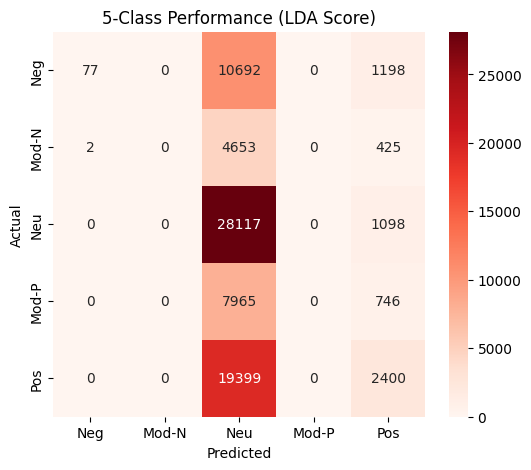

In [34]:
# map: Negative (-2) to Positive (+2) becasue order is going to be important
label_map_5 = {
    'negative': -2,
    'moderate_negative': -1,
    'neutral': 0,
    'moderate_positive': 1,
    'positive': 2
}

df['label_5_num'] = df['label_5'].map(label_map_5)

# Check for missing values after mapping
if df['label_5_num'].isnull().any():
    print("WARNING: Some labels failed to map. Dropping them for evaluation...")
    df = df.dropna(subset=['label_5_num'])

X = df['lda_score'].values.reshape(-1, 1)
y_5 = df['label_5_num'].values

# Fit Tree to find optimal thresholds
dt_5 = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_5.fit(X, y_5)
df['pred_5'] = dt_5.predict(X)

# Metrics
acc_5 = accuracy_score(y_5, df['pred_5'])
print(f"Accuracy (5-Class): {acc_5:.2%}")

# Visual: 5-Class Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_5, df['pred_5']), annot=True, fmt='d', cmap='Reds',
            xticklabels=['Neg', 'Mod-N', 'Neu', 'Mod-P', 'Pos'],
            yticklabels=['Neg', 'Mod-N', 'Neu', 'Mod-P', 'Pos'])
plt.title('5-Class Performance (LDA Score)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

As you can see from the heatmap above, the model is not performing well. In particular it is terrible at identifying 'moderate' cases and simply classifies all of them as neutral. This demonstrates that while LDA can capture broad sentiment polarity (positive vs negative), it lacks the granular semantic nuance required to distinguish 'moderate' from 'neutral' without supervised fine-tuning. It doesn't even do a great job at classifying positive or negative cases, it seems to classify the vast majority as neutral. This seems to reiterate the running idea that there may be a deficiency in the data pre-processing as many 'neutral' words are in each topic preventing the model from prediciting anything other than neutral. Or there may be some issues in the prediction step.

## 3 classes instead of 5

We examine the case of there being 3 labels instead of 5 below to test if the relatively small-sized moderate classes are having a major negative impact on the classification.

Accuracy (3-Class): 40.80%
Improvement: +0.95%


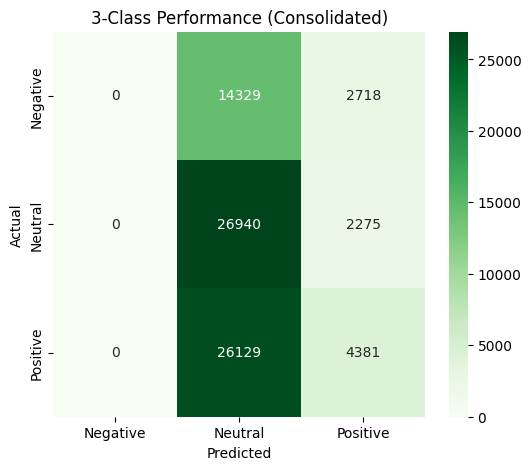

In [35]:
# map 5 classes down to 3
map_5_to_3 = {
    -2: -1, -1: -1,  # All Negatives -> -1
     0:  0,          # Neutral -> 0
     1:  1,  2:  1   # All Positives -> 1
}
df['label_3_num'] = df['label_5_num'].map(map_5_to_3)
y_3 = df['label_3_num'].values

# fit new Tree for 3 classes
dt_3 = DecisionTreeClassifier(max_depth=2, random_state=42)
dt_3.fit(X, y_3)
df['pred_3'] = dt_3.predict(X)

acc_3 = accuracy_score(y_3, df['pred_3'])
print(f"Accuracy (3-Class): {acc_3:.2%}")
print(f"Improvement: +{acc_3 - acc_5:.2%}")

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_3, df['pred_3']), annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('3-Class Performance (Consolidated)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

This performance is hardly better. In fact the model is shown to never predict negative which isn't good. I look to improve this next by trying a different dictionary to score the topics.

## Back to scoring the topics

This time I use the VADER dictionary to score the topics. This dictionary has better understanding of positive vs. negative [7] so I hope this improves the model's ability to predict these over neutral.

In [36]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
topic_sentiments_v = {}

#re-scoring the topics with VADER
for topic_id in range(8):
    word_map = dict(lda_model_4.show_topic(topic_id, topn=50))
    top_words = list(word_map.keys())

    topic_text = " ".join(top_words)

    # VADER returns a 'compound' score from -1 to +1
    score = analyzer.polarity_scores(topic_text)
    topic_sentiments_v[topic_id] = score['compound']

    print(f"Topic {topic_id}: VADER Score = {score['compound']:.3f}")

Topic 0: VADER Score = 0.765
Topic 1: VADER Score = 0.848
Topic 2: VADER Score = 0.908
Topic 3: VADER Score = -0.681
Topic 4: VADER Score = 0.878
Topic 5: VADER Score = 0.572
Topic 6: VADER Score = 0.599
Topic 7: VADER Score = 0.863


These scores are drastically different from the polarity scores produced by the LM dictionary!

I will also make a change to the prediction step below and force the decision tree to learn 'negative' even though it is a smaller proportion of the data.

In [37]:
predicted_scores_v = []

# loop through the corpus (which corresponds to your 'final_docs')
for i, doc_bow in tqdm(enumerate(corpus), total=len(corpus)):
    score = get_document_sentiment(doc_bow, lda_model_4, topic_sentiments_v)
    predicted_scores_v.append(score)

# add to your DataFrame for analysis
df['lda_score_v'] = predicted_scores_v

100%|██████████| 76772/76772 [00:12<00:00, 6104.28it/s] 


Accuracy (5-Class): 19.51%


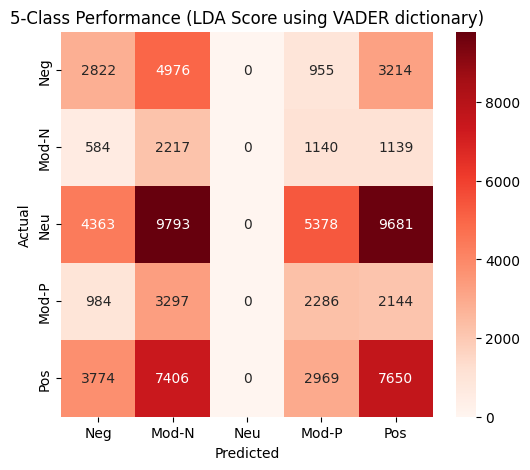

In [38]:
X_v = df['lda_score_v'].values.reshape(-1, 1)
y_5 = df['label_5_num'].values

dt_5_v = DecisionTreeClassifier(max_depth=4, random_state=42, class_weight='balanced')
dt_5_v.fit(X_v, y_5)
df['pred_5_v'] = dt_5_v.predict(X_v)

acc_5_v = accuracy_score(y_5, df['pred_5_v'])
print(f"Accuracy (5-Class): {acc_5_v:.2%}")

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_5, df['pred_5_v']), annot=True, fmt='d', cmap='Reds',
            xticklabels=['Neg', 'Mod-N', 'Neu', 'Mod-P', 'Pos'],
            yticklabels=['Neg', 'Mod-N', 'Neu', 'Mod-P', 'Pos'])
plt.title('5-Class Performance (LDA Score using VADER dictionary)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Ok so we appear to have swung the other way unfortunately and now the model isn't predicting neutral. I will try the same changes on the 3-class case and end my optimisation there.

Accuracy (3-Class): 33.95%


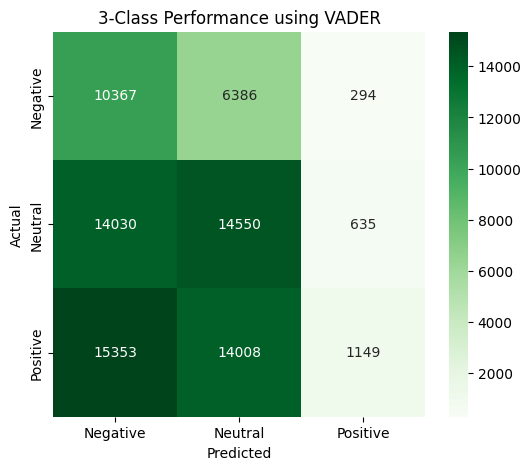

In [40]:
dt_3_v = DecisionTreeClassifier(max_depth=2, random_state=42, class_weight='balanced')
dt_3_v.fit(X_v, y_3)
df['pred_3_v'] = dt_3_v.predict(X_v)

acc_3_v = accuracy_score(y_3, df['pred_3_v'])
print(f"Accuracy (3-Class): {acc_3_v:.2%}")

plt.figure(figsize=(6, 5))
cm_3 = confusion_matrix(y_3, df['pred_3_v'])
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('3-Class Performance using VADER')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Evaluation of the process

From the heatmaps generated above it is clear that there is a sensitivity-stability tradeoff when using LDA. Without balancing, the model ignored 'Negative' (stable but insensitive). With balancing, it ignored 'Neutral' (sensitive but unstable).

There is also clearly a big impact on the model from the choice of dictionary used to produce topic sentiments. Initially, I used the Loughran-McDonald dictionary, but it yielded brittle polarity scores (often -1.0) because it excludes common positive news terms like 'good' or 'buy'. I contrasted this by switching to VADER, a lexicon optimized for social/news text, which provided a more continuous sentiment distribution. However the final 2 heatmaps clearly show this sacrficed accuracy of the model.

If I were to use LDA again, especially in this context, I would like to adjust the pre-processing step, specifically trying tf-idf data pre-processing to see if this improved performamce. Since I tried many different changes to the later aspects of the model and the prediction step, all without much improvement, I believe the next logical step would be to return to the initial key decisions within data pre-processing.

## Discussion about scalability

I tried 2 different LDA models - the standard LdaModel and the LdaMulticore version. LdaMulticore uses all CPU cores available which is crucial for scaling to millions of docs because it is designed to handle large-scale datasets more effectively than single-core implementations (like the standard LdaModel) by harnessing the power of multi-core machines. However this parallel processing implementation can result in a lower coherence score (as observed in this notebook) which is a drawback. A further extension which could theoretically be implemented is online LDA, which trains the model incrementally.

Furthermore, I identified early on that the linguistic pre-processing pipeline used for preparing the headlines for LDA was very slow - it was taking over 5 minutes for this dataset. If the data volume increased by a factor of 1000, this process would take approx. 3.5 days. I explored the use of a SpaCy's built-in feature .pipe() designed specifically for processing lists of text efficiently in batches, rather than one by one. This was more than 2x as quick as the original implementation which was great for the purposes of this project but not a sufficent scale solution. To handle data at scale, we would need to replace the single-machine spaCy pipeline with a distributed solution like Spark NLP, which allows lemmatization to be parallelized across a cluster of nodes.


## Comparison to finBERT

Due to the unsupervised nature of LDA, I evaluated the model's ability to cluster and score sentiment across the entire corpus. I then compared this 'Semantic Clustering' accuracy against the FinBERT supervised baseline. Although FinBERT was evaluated on a held-out test set, the unsupervised method demonstrates how effectively financial sentiment can be extracted from the entire data volume without requiring any label-based training.

While less accurate, this method of using LDA requires zero labeled training data - it learned entirely unsupervised. This is more time and cost effective than the supervised approach taken in fine tuning finBERT. Furthermore it addresses the challenge of finding sufficiently large, labelled datasets to train neural networks on since LDA does not require a labelled dataset. Hence, LDA is favourable over finBERT for scenarios where computational efficiency is the priority but when comparing model performance, finBERT is significantly better.

## Bibliography

* [1] P. Hajek & A. Barushka (2018) Integrating Sentiment Analysis and Topic Detection in Financial News for Stock Movement Prediction. https://doi.org/10.1145/3278252.3278267
* [2] M. Kelechava (2019) Using LDA Topic Models as a Classification Model Input. https://medium.com/
* [3] P. Kashyap (2024) Topic Modeling with Latent Dirichlet Allocation (LDA). https://medium.com/
* [4] T. Ghanoum (2021) Topic Modelling in Python with spaCy and Gensim. https://towardsdatascience.com/
* [5] P. Rao (2020) Turbo-charge your spaCy NLP pipeline. https://medium.com/
* [6] T. Loughran & B. Mcdonald (2016) Textual Analysis in Accounting and Finance: A Survey. https://doi.org/10.1111/1475-679X.12123
* [7] S.S. Pragnya (2022) VADER (Valence Aware Dictionary and sentiment Reasoner) Sentiment Analysis. https://medium.com/

